In [184]:
import math
import random
import pickle
import itertools

import numpy as np 
import pandas as pd 

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 

from sklearn.utils import shuffle

from scipy.signal import resample
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
np.random.seed(42)

In [185]:
import os
print(os.listdir("./heartbeat"))

['ptbdb_normal.csv', 'mitbih_test.csv', 'ptbdb_abnormal.csv', 'mitbih_train.csv']


In [399]:
df = pd.read_csv("./heartbeat/mitbih_train.csv", header=None)
df2 = pd.read_csv("./heartbeat/mitbih_test.csv", header=None)
df = pd.concat([df, df2], axis=0)

In [215]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [216]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB


In [217]:
df[187].value_counts()

0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: 187, dtype: int64

In [390]:
M = df.values
X = M[:, :-1]
y = M[:, -1].astype(int)

In [219]:
del df
del df2
del M

In [220]:
# Visual Input 

In [242]:
C0 = np.argwhere(y == 0).flatten()
C1 = np.argwhere(y == 1).flatten()
C2 = np.argwhere(y == 2).flatten()
C3 = np.argwhere(y == 3).flatten()
C4 = np.argwhere(y == 4).flatten()

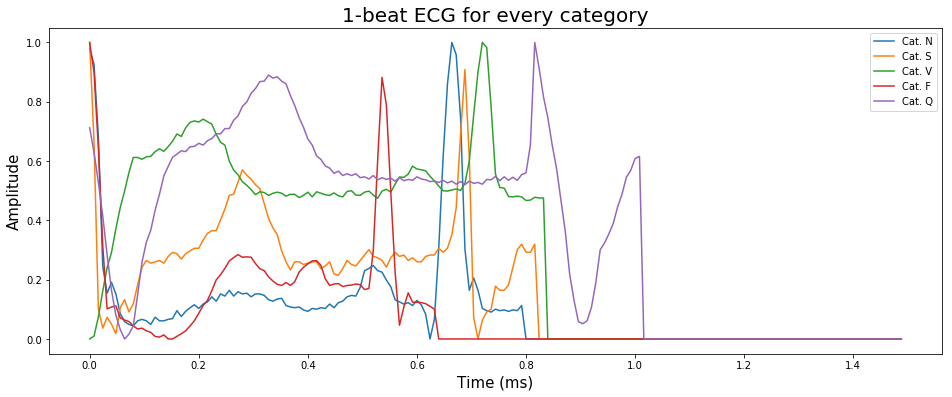

In [243]:
x = np.arange(0, 187)*8/1000

plt.figure(figsize=(16,6))
plt.plot(x, X[C0, :][0], label="Cat. N")
plt.plot(x, X[C1, :][0], label="Cat. S")
plt.plot(x, X[C2, :][0], label="Cat. V")
plt.plot(x, X[C3, :][0], label="Cat. F")
plt.plot(x, X[C4, :][0], label="Cat. Q")
plt.legend()
plt.title("1-beat ECG for every category", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

In [223]:
# Data augmentation
# Since there is not equal amount of data, we will augment to the smallest level.
# Hence, a set of 800

In [400]:
def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor

def augment(x):
    result = np.zeros(shape= (4, 187))
    for i in range(3):
        if random.random() < 0.33:
            new_y = stretch(x)
        elif random.random() < 0.66:
            new_y = amplify(x)
        else:
            new_y = stretch(x)
            new_y = amplify(new_y)
        result[i, :] = new_y
    return result


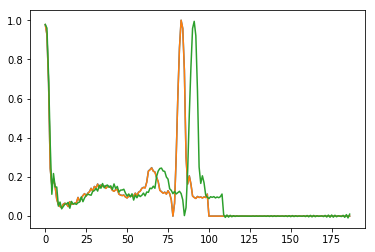

In [245]:
plt.plot(X[0, :])
plt.plot(amplify(X[0, :]))
plt.plot(stretch(X[0, :]))
plt.show()


In [246]:
result = np.apply_along_axis(augment, axis=1, arr=X[C3]).reshape(-1, 187)
classe = np.ones(shape=(result.shape[0],), dtype=int)*3
X = np.vstack([X, result])
y = np.hstack([y, classe])

In [401]:
X.shape

(109446, 187)

In [247]:
# Split

In [248]:
subC0 = np.random.choice(C0, 800)
subC1 = np.random.choice(C1, 800)
subC2 = np.random.choice(C2, 800)
subC3 = np.random.choice(C3, 800)
subC4 = np.random.choice(C4, 800)

(800,)

In [395]:
X_test = np.vstack([X[subC0], X[subC1], X[subC2], X[subC3], X[subC4]])
y_test = np.hstack([y[subC0], y[subC1], y[subC2], y[subC3], y[subC4]])

X_train = np.delete(X, [subC0, subC1, subC2, subC3, subC4], axis=0)
y_train = np.delete(y, [subC0, subC1, subC2, subC3, subC4], axis=0)

X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

In [230]:
del X
del y

In [397]:
print("X_test", X_test.shape)
print("X_test dimension", X_test.ndim)
print("X_test size", X_test.size)
print("X_test type", type(X_test))

X_test (4000, 187)
X_test dimension 2
X_test size 748000
X_test type <class 'numpy.ndarray'>


In [278]:
X_test[0][0]

0.5245901346206665

In [268]:
# Expand the shape of array
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

In [274]:
X_test[0][0][0]

0.5245901346206665

In [283]:
X_test

array([[0.52, 0.48, 0.28, ..., 0.  , 0.  , 0.  ],
       [0.92, 0.72, 0.38, ..., 0.  , 0.  , 0.  ],
       [0.94, 0.88, 0.82, ..., 0.  , 0.  , 0.  ],
       ...,
       [0.99, 0.98, 0.85, ..., 0.  , 0.  , 0.  ],
       [0.89, 1.  , 0.96, ..., 0.  , 0.  , 0.  ],
       [1.  , 0.77, 0.45, ..., 0.  , 0.  , 0.  ]])

In [239]:
print("X_test", X_test.shape)
print("X_test dimension", X_test.ndim)
print("X_test size", X_test.size)
print("X_test type", type(X_test))

X_test (4000, 187, 1)
X_test dimension 3
X_test size 748000
X_test type <class 'numpy.ndarray'>


In [279]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (109140, 187)
y_train (109140,)
X_test (4000, 187)
y_test (4000,)


In [151]:
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [152]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (121984, 187, 1)
y_train (121984, 5)
X_test (4000, 187, 1)
y_test (4000, 5)


In [78]:
# Model

In [153]:
# Keras import
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation# , Dropout
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [154]:
n_obs, feature, depth = X_train.shape
batch_size = 500

In [155]:
inp = Input(shape=(feature, depth))
C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)

C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
A11 = Activation("relu")(C11)
C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
M11 = MaxPooling1D(pool_size=5, strides=2)(A12)


C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
A21 = Activation("relu")(C21)
C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
S21 = Add()([C22, M11])
A22 = Activation("relu")(S11)
M21 = MaxPooling1D(pool_size=5, strides=2)(A22)


C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
A31 = Activation("relu")(C31)
C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
S31 = Add()([C32, M21])
A32 = Activation("relu")(S31)
M31 = MaxPooling1D(pool_size=5, strides=2)(A32)


C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
A41 = Activation("relu")(C41)
C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
S41 = Add()([C42, M31])
A42 = Activation("relu")(S41)
M41 = MaxPooling1D(pool_size=5, strides=2)(A42)


C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
A51 = Activation("relu")(C51)
C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
S51 = Add()([C52, M41])
A52 = Activation("relu")(S51)
M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

F1 = Flatten()(M51)

D1 = Dense(32)(F1)
A6 = Activation("relu")(D1)
D2 = Dense(32)(A6)
D3 = Dense(5)(D2)
A7 = Softmax()(D3)

model = Model(inputs=inp, outputs=A7)

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 187, 1)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 183, 32)      192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 183, 32)      5152        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 183, 32)      0           conv1d_2[0][0]                   
__________

In [156]:
def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.75
    t = n_obs//(10000 * batch_size)  # every epoch we do n_obs/batch_size iteration
    lrate = initial_lrate * math.exp(-k*t)
    return lrate

lrate = LearningRateScheduler(exp_decay)

In [157]:
adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)

In [158]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, 
                    epochs=75, 
                    batch_size=batch_size, 
                    verbose=2, 
                    validation_data=(X_test, y_test), 
                    callbacks=[lrate])

In [38]:
# Save Model
# model.save('heartClassification.h5')

In [171]:
# Load Model
from tensorflow.keras.models import load_model

In [280]:
model = load_model('heartClassification.h5')

In [86]:
# The categories [0-4] defined in column V188 are

# ‘N’: 0, ‘S’: 1, ‘V’: 2, ‘F’: 3, ‘Q’: 4

# These correspond to

# N: Normal beat
# S: Supraventricular premature beat
# V: Premature ventricular contraction
# F: Fusion of ventricular and normal beat
# Q: Unclassifiable beat

In [173]:
y_pred = model.predict(X_test, batch_size=1000)

In [174]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97       800
           1       0.99      0.95      0.97       800
           2       0.99      0.99      0.99       800
           3       0.99      0.97      0.98       800
           4       1.00      1.00      1.00       800

    accuracy                           0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000



In [175]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [1]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

In [372]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],
                      title='Confusion matrix, without normalization')
plt.show()

In [298]:
testPred = X_test
testPred = np.expand_dims(testPred, 2)

In [413]:
 a = np.zeros((1, 187))
a = np.array(a)

a = np.expand_dims(a, 2)

In [414]:
a.shape

(1, 187, 1)

In [412]:
a.shape

(2, 187, 1)

In [370]:
yPred = model.predict(a, batch_size=1)

Confusion matrix, without normalization


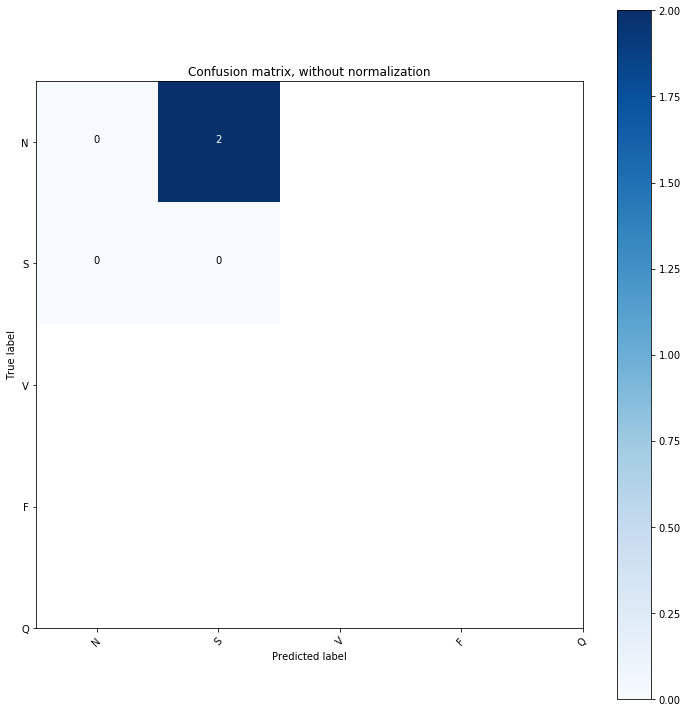

In [371]:
cnf_matrix = confusion_matrix(a.argmax(axis=1), yPred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],
                      title='Confusion matrix, without normalization')
plt.show()

In [402]:
model._make_predict_function()   